In [1]:
import nltk
import re
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
import pylab as pl

from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory, StopWordRemover, ArrayDictionary

In [2]:
def preprocess(tweet):
    
    #Convert www.* or https?://* to URL
    tweet = re.sub('((www\.[^\s]+)|(https?://[^\s]+))','URL',tweet)
    
    #Convert @username to AT_USER
    tweet = re.sub('@[^\s]+','AT_USER',tweet)  
    
    #Replace #word with word
    tweet = re.sub(r'#([^\s]+)', r'\1', tweet)
    
    #trim
    tweet = tweet.strip('\'"')
    
    # Repeating words like hellloooo
    repeat_char = re.compile(r"(.)\1{1,}", re.IGNORECASE)
    tweet = repeat_char.sub(r"\1\1", tweet)
    
    #Emoticons
    emoticons = \
    [
     ('__positive__',[ ':-)', ':)', '(:', '(-:', \
                       ':-D', ':D', 'X-D', 'XD', 'xD', \
                       '<3', ':\*', ';-)', ';)', ';-D', ';D', '(;', '(-;', ] ),\
     ('__negative__', [':-(', ':(', '(:', '(-:', ':,(',\
                       ':\'(', ':"(', ':((','D:' ] ),\
    ]

    def replace_parenthesis(arr):
       return [text.replace(')', '[)}\]]').replace('(', '[({\[]') for text in arr]
    
    def join_parenthesis(arr):
        return '(' + '|'.join( arr ) + ')'

    emoticons_regex = [ (repl, re.compile(join_parenthesis(replace_parenthesis(regx))) ) \
            for (repl, regx) in emoticons ]
    
    for (repl, regx) in emoticons_regex :
        tweet = re.sub(regx, ' '+repl+' ', tweet)

    # Convert to lower case (Case folding)
    tweet = tweet.lower()
    
    return tweet

In [3]:
#start getStopWordList
def getStopWordList():
    #read the stopwords file and build a list
    stopWords = []
    
    fp = open('trainingandtestdata/stopwordsID.txt', 'r')
    line = fp.readline()
    while line:
        word = line.strip()
        stopWords.append(word)
        line = fp.readline()
    fp.close()
    return stopWords

In [4]:
#Stemming of Tweets

def stem(tweet):
        # create stemmer
        factory = StemmerFactory()
        stemmer = factory.create_stemmer() #bahasa
        # stemmer = nltk.stem.PorterStemmer() # english
        tweet_stem = ''
        words = [word if(word[0:2]=='__') else word.lower() \
                    for word in tweet.split() \
                    if len(word) >= 3]
        words = [stemmer.stem(w) for w in words] 
        tweet_stem = ' '.join(words)       
        
        return tweet_stem


In [5]:
def stopWordRemoval(tweet):
    # Get default stopword
    stop_factory = StopWordRemoverFactory().get_stop_words()
    more_stopword = getStopWordList()

    # Merge stopword
    data = stop_factory + more_stopword

    dictionary = ArrayDictionary(data)
    str = StopWordRemover(dictionary)

    return str.remove(tweet)

In [6]:
dataset = pd.read_csv('trainingandtestdata/gojek_twitter_dataset.csv',encoding='ISO-8859-1')
dataset

,tweet,sentimen
0,Saya juga mau vouchee @gojekindonesia https:/...,1
1,download gojek duluuu uwuwu,1
2,Aminnn...#orderan goride mhn di lancar kan.all...,1
3,Tq @gojekindonesia @golifeindonesia ð¤. Haru...,1
4,Semoga Twitter panjang umur. Berkomunikasi den...,1
5,"Semoga di tahun yang baru ini, kita senantiasa...",1
6,Sejauh ini menurut saya UI paling nyaman dari ...,1
7,Thank you @gojekindonesia pic.twitter.com/pbZ...,1
8,"Hai, ada yang bisa kami bantu mengenai layanan...",1
9,Full Week Feeling Great With You Guys @gojekin...,1


In [7]:
dataset.sentimen.value_counts()

0    3062
1     938
Name: sentimen, dtype: int64

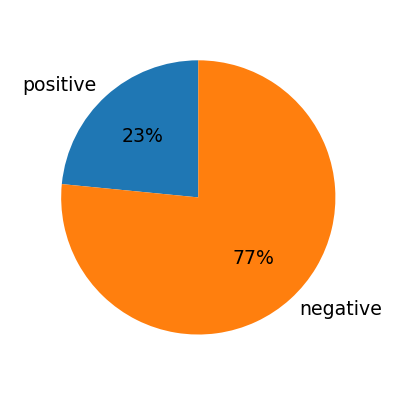

In [8]:
import matplotlib.pyplot as plt

amount_of_positive = dataset.sentimen.value_counts()[1]
amount_of_negative = dataset.sentimen.value_counts()[0]
category_names = ['positive', 'negative']
sizes = [amount_of_positive, amount_of_negative]

plt.figure(figsize=(2, 2), dpi=227)
plt.pie(sizes, labels=category_names, textprops={'fontsize': 6}, startangle=90, 
       autopct='%1.0f%%')
plt.show()

In [9]:
X=dataset.iloc[:,0].values
X=pd.Series(X)
y=dataset.iloc[:,1].values

X        


0       Saya juga mau vouchee @gojekindonesia  https:/...
1                             download gojek duluuu uwuwu
2       Aminnn...#orderan goride mhn di lancar kan.all...
3       Tq @gojekindonesia @golifeindonesia ð¤. Haru...
4       Semoga Twitter panjang umur. Berkomunikasi den...
5       Semoga di tahun yang baru ini, kita senantiasa...
6       Sejauh ini menurut saya UI paling nyaman dari ...
7       Thank you @gojekindonesia  pic.twitter.com/pbZ...
8       Hai, ada yang bisa kami bantu mengenai layanan...
9       Full Week Feeling Great With You Guys @gojekin...
10      Happy Sunday everyone â¤â¤\nMinggu santai me...
11      You can donate via @gojekindonesia application...
12      Jogja terasa sangat indah pagi ini dengan MOTO...
13      Satu kesuksesan pelatih adalah di saat pemain ...
14      Engga sih, soalnya gua udah instal aplikasi @g...
15      Tgl 28 kemaren baru d tf bpk 200rb, sekarang u...
16      Pasti selalu Ada jalannya tenang aja ye gak @g...
17            

In [10]:
# preprocessing
X = [preprocess(tweet) for tweet in X]
# stop word removal
X = [stopWordRemoval(tweet) for tweet in X]
# stemming
X = [stem(tweet) for tweet in X]
X

['vouchee url ',
 'download gojek duluu uwuwu',
 'aminn order goride mhn lancar kan all driver kecuali pakai mod tuyul',
 '  5 0 khusus daerah bandung therapist hubungin nomor kartu pic twitter com 5jmnmnmnhq',
 'moga twitter umur komunikasi sedia jasa indonesia never been this easy just mentioned once tanggap and fast response twitter long live twitter',
 'moga ini senantiasa jalan lurus jalan baik jalan tuntun pintu surga selamat islam muharam 1441 islamicnewyear tahunbaruislam muharram1441 pastiadajalan pic twitter com qpabdmyzim',
 'nyaman app asli indonesia punya',
 'thank you pic twitter com pbzbg8lkf7',
 'hai bantu layan gojek terima kasih yun',
 'full week feeling great with you guys terima kasih terima kasih gojek grab driver for this week  moga penuh berkah kirim tulus halau url ',
 'happy sunday everyone  minggu santai jelang makan siang yuk order gofood powered at user available ikan bakar goreng nila mas mujaer bawal lele  ikan bakar biduri url',
 'you can donate via appli

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.20, random_state=5)


vec = TfidfVectorizer(min_df=5, max_df=0.95, sublinear_tf = True,use_idf = True,ngram_range=(1, 2))
X_train_vec = vec.fit_transform(X_train)
nb = MultinomialNB()
nb.fit(X_train_vec,y_train)
X_test_vec = vec.transform(X_test)
pred = nb.predict(X_test_vec)

print(metrics.accuracy_score(y_test, pred))

0.7875


In [12]:
y_test.mean()

0.22375

In [13]:
1-y_test.mean()

0.77625

In [14]:
print(metrics.confusion_matrix(y_test, pred))

[[607  14]
 [156  23]]


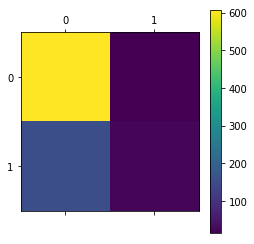

              precision    recall  f1-score   support

           0       0.80      0.98      0.88       621
           1       0.62      0.13      0.21       179

   micro avg       0.79      0.79      0.79       800
   macro avg       0.71      0.55      0.55       800
weighted avg       0.76      0.79      0.73       800



In [15]:
cm = metrics.confusion_matrix(y_test, pred)
pl.matshow(cm)
#pl.title('Confusion matrix of the classifier')
pl.colorbar()
pl.show()

print(metrics.classification_report(y_test, pred))